# 목차  
[1. 데이터/라이브러리 불러오기](#데이터라이브러리-불러오기)  
[2. 숙소 형태 기준](#숙소-형태-기준-세부-카테고리-분류)  
[3. 가격대 기준](#가격대-기준-세부-카테고리-분류)  
[3-1. 데이터 분포 기반](#1-데이터-분포-기반)  
[3-2. k-means 군집화 기반](#2-k-means-군집화-기반)  
[4. 숙소+가격대 기준](#숙소--가격대-기준-세부카테고리-분류)  
[5. 주관적인 기준](#주관적인-기준으로-분류)  

## 데이터/라이브러리 불러오기

In [56]:
# 라이브러리 불러오기기
import pandas as pd
import matplotlib.pyplot as plt
import openai
import json
import os
from dotenv import load_dotenv

In [3]:
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, '..', 'data')
data_file_path = os.path.join(data_directory, 'filter_df.pickle')
df = pd.read_pickle(data_file_path)

In [41]:
df = df[~df['title'].str.contains('임대|야놀자|입장권|상품권|포인트|야놀|주차권|쿠폰|구매|비행기|종일권|자유이용권', na=False)]
df.reset_index(drop=True, inplace=True)

## 숙소 형태 기준 세부 카테고리 분류

일단은 title 키워드 기반으로 나눈거라 부정확할수도 있음

In [42]:
df['stay_type'] = "기타"
df.loc[df['title'].str.contains('호텔', na=False), 'stay_type'] = '호텔'
df.loc[df['title'].str.contains('노보텔', na=False), 'stay_type'] = '호텔'
df.loc[df['title'].str.contains('모텔', na=False), 'stay_type'] = '모텔'
df.loc[df['title'].str.contains('리조트', na=False), 'stay_type'] = '리조트'
df.loc[df['title'].str.contains('펜션', na=False), 'stay_type'] = '펜션'
df.loc[df['title'].str.contains('풀빌라', na=False), 'stay_type'] = '풀빌라'

In [76]:
df['stay_type'].value_counts()

stay_type
호텔     302
기타     148
리조트     27
펜션       6
모텔       4
풀빌라      4
Name: count, dtype: int64

## 가격대 기준 세부 카테고리 분류

### 1. 데이터 분포 기반

In [5]:
df['price_category(quantile)'] = pd.qcut(df['price'], 4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

In [6]:
df['price_category(quantile)'].value_counts()

price_category(quantile)
Low         139
Mid-High    129
High        118
Mid-Low     116
Name: count, dtype: int64

In [7]:
df.groupby('price_category(quantile)')['price'].describe()

C:\Users\gmldu\AppData\Local\Temp\ipykernel_32032\2657837685.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('price_category(quantile)')['price'].describe()


,count,mean,std,min,25%,50%,75%,max
price_category(quantile),,,,,,,,
Low,139.0,56678.287770,25770.374626,20000.0,34500.0,55000.0,79500.0,100000.0
Mid-Low,116.0,162366.413793,31085.476384,110000.0,137500.0,160000.0,190000.0,210000.0
Mid-High,129.0,314573.023256,54667.258062,220000.0,260000.0,300000.0,360000.0,400000.0
High,118.0,717603.822034,283736.646421,409000.0,500000.0,600000.0,940000.0,2000000.0


20000~100000, 110000 ~ 210000, 220000~400000, 409000+

In [80]:
df.groupby('price_category(quantile)')['stay_type'].value_counts()

C:\Users\gmldu\AppData\Local\Temp\ipykernel_32032\4021536491.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('price_category(quantile)')['stay_type'].value_counts()


price_category(quantile)  stay_type
Low                       호텔           83
                          기타           35
                          펜션            4
                          모텔            4
                          리조트           2
                          풀빌라           0
Mid-Low                   호텔           57
                          기타           42
                          리조트          14
                          풀빌라           3
                          펜션            0
                          모텔            0
Mid-High                  호텔           85
                          기타           36
                          리조트           6
                          펜션            2
                          모텔            0
                          풀빌라           0
High                      호텔           77
                          기타           35
                          리조트           5
                          풀빌라           1
                          모텔            

### 2. k-means 군집화 기반

c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

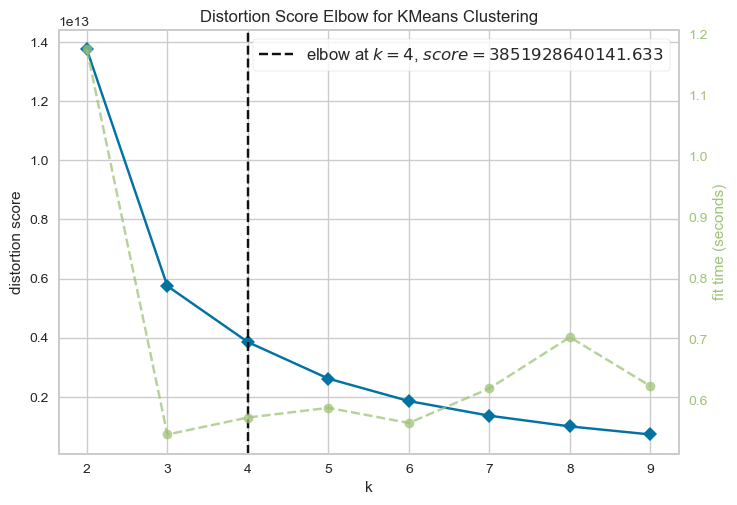

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

model = KMeans(random_state=1004)
visualizer = KElbowVisualizer(model, k=(2, 10))  # 2에서 10까지 군집 수를 테스트
visualizer.fit(df['price'].values.reshape(-1, 1))  # 데이터에 맞춰 학습
visualizer.show()  # 그래프 출력

In [16]:
# K-means 클러스터링
kmeans = KMeans(n_clusters=4, random_state=1004)
df['price_cluster'] = kmeans.fit_predict(df[['price']])

c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [20]:
df.groupby('price_cluster')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
price_cluster,,,,,,,,
0,149.0,3.313350e+05,66723.791207,220000.0,270000.0,330000.0,390000.0,460000.0
1,37.0,1.072003e+06,211426.407258,900000.0,950000.0,1000000.0,1111111.0,2000000.0
2,255.0,1.047560e+05,59824.741979,20000.0,50000.0,100000.0,156100.0,210000.0
3,61.0,5.938382e+05,106043.753541,470000.0,500000.0,560000.0,650000.0,800000.0


20000~210000, 220000~460000, 470000~800000, 900000+

In [47]:
df.groupby('price_cluster')['stay_type'].value_counts()

price_cluster  stay_type
0              호텔           100
               기타            40
               리조트            7
               펜션             2
1              호텔            19
               기타            17
               리조트            1
2              호텔           140
               기타            77
               리조트           16
               모텔             4
               펜션             4
               풀빌라            3
3              호텔            43
               기타            14
               리조트            3
               풀빌라            1
Name: count, dtype: int64

## 숙소 + 가격대 기준 세부카테고리 분류

c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

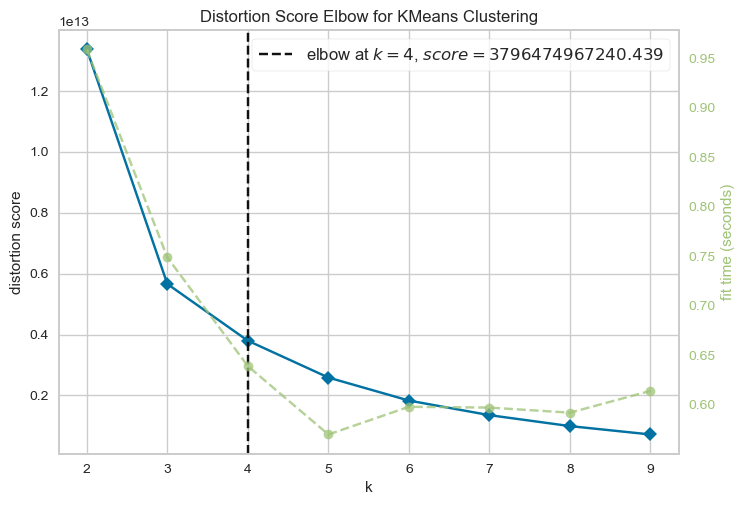

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [50]:
df_encoded = pd.get_dummies(df, columns=['stay_type'])

model = KMeans(random_state=1004)
visualizer = KElbowVisualizer(model, k=(2, 10))

visualizer.fit(df_encoded[['price'] + list(df_encoded.columns[df_encoded.columns.str.startswith('stay_type_')])])
visualizer.show()

In [51]:
# K-means 클러스터링
kmeans = KMeans(n_clusters=4, random_state=1004)
df['price_stay_cluster'] = kmeans.fit_predict(df_encoded[['price'] + list(df_encoded.columns[df_encoded.columns.str.startswith('stay_type_')])])

c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [52]:
df['price_stay_cluster'].value_counts()

price_stay_cluster
1    244
2    149
3     61
0     37
Name: count, dtype: int64

In [83]:
df.groupby('price_stay_cluster')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
price_stay_cluster,,,,,,,,
0,37.0,1.072003e+06,211426.407258,900000.0,950000.0,1000000.0,1111111.0,2000000.0
1,244.0,1.078065e+05,59268.943563,20000.0,53750.0,100000.0,160000.0,210000.0
2,149.0,3.313350e+05,66723.791207,220000.0,270000.0,330000.0,390000.0,460000.0
3,61.0,5.938382e+05,106043.753541,470000.0,500000.0,560000.0,650000.0,800000.0


In [53]:
df.groupby('price_stay_cluster')['stay_type'].value_counts()

price_stay_cluster  stay_type
0                   호텔            19
                    기타            17
                    리조트            1
1                   호텔           140
                    기타            77
                    리조트           16
                    모텔             4
                    펜션             4
                    풀빌라            3
2                   호텔           100
                    기타            40
                    리조트            7
                    펜션             2
3                   호텔            43
                    기타            14
                    리조트            3
                    풀빌라            1
Name: count, dtype: int64

In [55]:
df.groupby('price_stay_cluster')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
price_stay_cluster,,,,,,,,
0,37.0,1.072003e+06,211426.407258,900000.0,950000.0,1000000.0,1111111.0,2000000.0
1,244.0,1.078065e+05,59268.943563,20000.0,53750.0,100000.0,160000.0,210000.0
2,149.0,3.313350e+05,66723.791207,220000.0,270000.0,330000.0,390000.0,460000.0
3,61.0,5.938382e+05,106043.753541,470000.0,500000.0,560000.0,650000.0,800000.0


## 주관적인 기준으로 분류  
- 축제, 콘서트 등 이벤트 관련 숙소  
- 외국 숙소  
- 국내에서 가격대가 높은 숙소  
- 국내에서 가격대가 낮은 숙소  
- 호텔 외(모텔, 리조트, 펜션)  

In [67]:
df['my_category']=df['stay_type']

In [ ]:
df['stay_type'] = "기타"
df.loc[df['title'].str.contains('호텔', na=False), 'stay_type'] = '호텔'
df.loc[df['title'].str.contains('노보텔', na=False), 'stay_type'] = '호텔'
df.loc[df['title'].str.contains('모텔', na=False), 'stay_type'] = '모텔'
df.loc[df['title'].str.contains('리조트', na=False), 'stay_type'] = '리조트'
df.loc[df['title'].str.contains('펜션', na=False), 'stay_type'] = '펜션'
df.loc[df['title'].str.contains('풀빌라', na=False), 'stay_type'] = '풀빌라'

In [60]:
from collections import Counter
noun_counts = Counter(
    noun for sublist in df['title_nouns'] for noun in sublist
)

In [64]:
foreign_list = '오키나와|하카타|싱가폴|하바나|시리아|나고야|베트남|재팬|캐나다|루체른|싱가포르|아메리카|카프리섬|하카타|코타키나발루|미야자키|하와이|도톤보리|칼튼|방콕|시부야|마드리드|뮌헨|치앙마이|대만|파타야|일본|후쿠오카|도쿄|이탈리아|오사카'

In [69]:
df.loc[df['title'].str.contains(foreign_list),'my_category'] = '외국 숙소'

In [70]:
df.loc[df['title'].str.contains('축제|콘서트|콘|페스트|페스티벌'),'my_category'] = '축제/콘서트 숙소'

In [73]:
df[df['my_category']=='호텔']['price'].mean()

270321.35802469135

In [74]:
# '호텔'의 평균 가격 계산
hotel_price_mean = df[df['my_category'] == '호텔']['price'].mean()

# 가격대에 따라 값을 채우는 함수 정의
def categorize_hotel_price(row):
    if row['my_category'] == '호텔':
        if row['price'] > hotel_price_mean:
            return '가격대 높은 호텔'
        else:
            return '가격대 낮은 호텔'
    return row['my_category']

# apply를 사용해 가격대를 채우는 작업
df['my_category'] = df.apply(categorize_hotel_price, axis=1)

In [75]:
df['my_category'].value_counts()

my_category
가격대 낮은 호텔    139
기타           112
가격대 높은 호텔    104
외국 숙소         52
축제/콘서트 숙소     45
리조트           25
펜션             6
모텔             4
풀빌라            4
Name: count, dtype: int64

In [84]:
df.groupby('my_category')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
my_category,,,,,,,,
가격대 낮은 호텔,139.0,114044.395683,69589.978984,20000.0,60000.0,100000.0,161500.0,260000.0
가격대 높은 호텔,104.0,479191.528846,210865.416660,278000.0,347990.0,410000.0,527500.0,1500000.0
기타,112.0,295104.892857,324062.999805,20500.0,111111.0,200000.0,325000.0,2000000.0
리조트,25.0,278532.440000,224619.724109,100000.0,160000.0,200000.0,290000.0,1111111.0
모텔,4.0,43000.000000,27006.172134,20000.0,20000.0,40000.0,63000.0,72000.0
외국 숙소,52.0,265859.192308,232972.379277,24000.0,122500.0,205000.0,359250.0,1234567.0
축제/콘서트 숙소,45.0,666980.666667,316332.328848,36000.0,390000.0,690000.0,940000.0,1300000.0
펜션,6.0,140000.000000,151756.383721,30000.0,38750.0,65000.0,203750.0,400000.0
풀빌라,4.0,252000.000000,232211.110845,129000.0,129000.0,139500.0,262500.0,600000.0


In [82]:
df.groupby('stay_type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
stay_type,,,,,,,,
기타,148.0,329180.729730,333715.574287,20500.0,111111.0,200000.0,400000.0,2000000.0
리조트,27.0,281233.740741,219247.773183,100000.0,165000.0,200000.0,315000.0,1111111.0
모텔,4.0,43000.000000,27006.172134,20000.0,20000.0,40000.0,63000.0,72000.0
펜션,6.0,140000.000000,151756.383721,30000.0,38750.0,65000.0,203750.0,400000.0
풀빌라,4.0,252000.000000,232211.110845,129000.0,129000.0,139500.0,262500.0,600000.0
호텔,302.0,308708.271523,269051.153618,20000.0,100000.0,258000.0,409750.0,1500000.0
